# Text Classification

In this one I will be downloading movie review data and classifying the data as "positive" or "negative". That is, doing sentiment analysis on the text data. Using the link below

https://www.tensorflow.org/tutorials/keras/text_classification

In [30]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

plt.style.use('dark_background')

In [4]:
if not os.path.exists('./aclImdb/'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                        untar=True, cache_dir='.',
                                        cache_subdir='')

    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
else:
    dataset_dir = './aclImdb/'
os.listdir(dataset_dir)

84131840/84125825 [==============================] - 9s 0us/step


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
"""
Loading the dataset will require us to use the test_data_for_direcotry utility. This requires data to be
in the exact format that it is in above - how convienent.
"""
# This dir does not matter to us - get rid of it
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
# Load the data in
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, # 80/20 training/validation data
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
# Showing some data samples
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review:", text_batch.numpy()[i][:100])
        print("Label:", label_batch.numpy()[i])

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
Label: 0
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was"
Label: 0
Review: b'Great documentary about the lives of NY firefighters during the worst terrorist attack of all time..'
Label: 1


In [11]:
# But what does 0 and 1 mean?
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
# Now get the validation data set - make sure to use the same seed or specify shuffle=False
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
# Now get the test data
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Training, Validation, Testing
Quick note for those that don't know - Training data is what we train on, Validation data is what
we validate the model on. That is, it is the data is used to see how the data is doing during training
Finally, test data is what we plan to use to actually test the model when it is done

### Standardize, tokenize, vectorize
Standardize removes extras such as punctuaion, and HTML takes. Tokenize splits the strings into the indidivual words and vectorization converts the words (tokens) into numbers so the neural network can actually use them.

In [14]:
def custom_standardization(input_data):
    """
    preprocessing.TextVectorization does not  strip HTML tag by default. We create this method to do
    exactly that
    """
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
max_features = 10000
sequence_length = 250

# Convert to vector
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
type(vectorize_layer)

tensorflow.python.keras.layers.preprocessing.text_vectorization.TextVectorization

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Vectorized review: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br /

In [20]:
aa = 367
print(f"{aa} ---> ",vectorize_layer.get_vocabulary()[aa])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

367 --->  recommend
Vocabulary size: 10000


In [21]:
# Apply the vectorization to all three sets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
# Optimization for memory - load into memory and get before using (prefetch)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# Create model
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Pausing here to go to tutorial 03_word_embedding
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 81s 128ms/step - loss: 0.6817 - binary_accuracy: 0.6163 - val_loss: 0.6143 - val_binary_accuracy: 0.7710
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5797 - binary_accuracy: 0.7849 - val_loss: 0.4983 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4663 - binary_accuracy: 0.8377 - val_loss: 0.4201 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3908 - binary_accuracy: 0.8625 - val_loss: 0.3737 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3437 - binary_accuracy: 0.8786 - val_loss: 0.3451 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3098 - binary_accuracy: 0.8863 - val_loss: 0.3259 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 5s 7ms/

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 309s 391ms/step - loss: 0.3101 - binary_accuracy: 0.8735
Loss:  0.31014153361320496
Accuracy:  0.8734800219535828


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

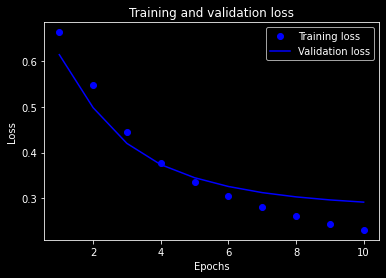

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

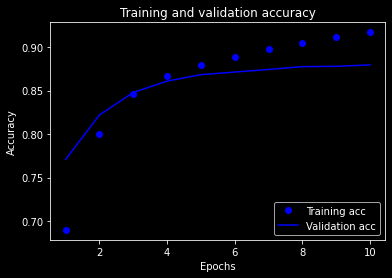

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()